In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.patches import Patch
from os import listdir
import numpy as np
from collections import defaultdict

sns.set(style="ticks", font_scale=1.2, font="Arial")

def render(outpath=None):
    if outpath is not None:
        plt.savefig(f"../figures/{outpath}", dpi=300, bbox_inches="tight")
        print("Rendered figure")

# Plotting constants

In [2]:
PHENOMENA = [
    "Anaphora", "Center Embedding", "Comparative Illusion", "Intrusive Resumption",
    "NPIs", "Order of Adjectives", "Order of Adverbs", "Plural Attraction"
]
PHENOMENA_LABELS = []
for phen in PHENOMENA:
    if "Order of" in phen:
        phen_label = phen.replace("of ", "of \n")
    else:
        phen_label = phen.replace(" ", "\n")
    PHENOMENA_LABELS.append(phen_label)

MODELS = ["text-davinci-002", "text-davinci-003"]
MODEL_MAP = {"text-davinci-002": "davinci2", "text-davinci-003": "davinci3"}
MODEL_LABELS = [MODEL_MAP[m] for m in MODELS]

# Global helper functions

In [3]:
def read_model_csvs(folder, model_substr=None):
    """Helper function for reading CSV files from a folder.
    Expects files to be named by model."""
    files = listdir(folder)
    dfs = []
    for f in files:
        # Only read files containing the specified substring.
        if model_substr is not None and model_substr not in f:
            continue
        df = pd.read_csv(f"{folder}/{f}")
        df["model"] = f.replace(".csv", "")
        dfs.append(df)
    df = pd.concat(dfs)
    return df

def get_sentence_num(phenomenon, test_item):
    """Helper function for converting from DGL's original
    phenomenon + test item indexing (e.g., Anaphora TS 4)
    to a global indexer for all 80 experimental stimuli.
    The sentence numbers are in the range 3-82."""
    if phenomenon == "Plural Attraction control":
        return None
    # Test item list is sorted alphabetically, so TS 10 comes before TS 2.
    test_items = [
        "TS 1", "TS 10", "TS 2", "TS 3", "TS 4",
        "TS 5", "TS 6", "TS 7", "TS 8", "TS 9"
    ]
    phen_idx = PHENOMENA.index(phenomenon)
    test_item_idx = test_items.index(test_item)
    sentence_num = phen_idx*10 + test_item_idx + 3 # to offset the attention checks
    return sentence_num

def try_index(df, index):
    """Helper function for trying to look up data from a dataframe."""
    try:
        return df.loc[index]
    except:
        return None

# Figure 1a: Minimal pair accuracy

## Step 1: Read and process model surprisal data

In [4]:
def process_minimal_pair_data(folder="minimal_pairs", models=None):
    """Main function for reading minimal pair surprisal data."""
    # Read sentence-level surprisals.
    df = read_model_csvs(f"../data/model_outputs/{folder}/sentence_surprisals")
    
    if models is not None:
        # Optionally subset models.
        df = df[df.model.isin(models)]
        
    # Rename "Comparative Sentences" to "Comparative Illusion",
    # to be consistent with human data (inconsistency in DGL's data).
    df["phenomenon"] = df.phenomenon.replace({
        "Comparative Sentences": "Comparative Illusion"
    })
        
    df.rename(columns={
        f"sum_surprisal_{cond}": f"sum_surprisal_{cond}_with_bos"
        for cond in ["grammatical", "ungrammatical"]
    }, inplace=True)
    
    # Compute mean surprisals.
    token_df = read_model_csvs(f"../data/model_outputs/{folder}/token_surprisals")
    token_df["phenomenon"] = token_df.phenomenon.replace({
        "Comparative Sentences": "Comparative Illusion"
    })
    # Don't count surprisal of <s> token.
    token_df = token_df[token_df.token!="<s>"].groupby(["phenomenon", "test_item", "condition", "model"])
    means = token_df.surprisal.mean().to_frame()
    sum_no_bos = token_df.surprisal.sum().to_frame()
    
    # Read frequency data.
    freq = pd.read_csv("../data/minimal_pair_coca_freq.csv")
    freq["phenomenon"] = freq.phenomenon.replace({
        "Comparative Sentences": "Comparative Illusion"
    })
    freq = freq.set_index(
        ["phenomenon", "test_item"]
    )

    # Add relevant metrics.
    for cond in ["grammatical", "ungrammatical"]:
        df[f"mean_surprisal_{cond}"] = df.apply(
            lambda r: try_index(means, (r.phenomenon, r.test_item, cond, r.model)),
            axis=1
        )
        df[f"sum_surprisal_{cond}"] = df.apply(
            lambda r: try_index(sum_no_bos, (r.phenomenon, r.test_item, cond, r.model)),
            axis=1
        )     
        df[f"mean_log_freq_{cond}"] = df.apply(
            lambda r: freq.loc[r.phenomenon, r.test_item][f"mean_log_freq_{cond}"],
            axis=1
        )
        # Add SLOR metric (Lau et al. 2017, https://onlinelibrary.wiley.com/doi/full/10.1111/cogs.12414).
        df[f"slor_{cond}"] = -df[f"mean_surprisal_{cond}"] - df[f"mean_log_freq_{cond}"]
        
        
    df = df.reset_index().drop(columns=["index"])
    
    # Do finagling of the Order of Adjectives phenomenon.
    for model in df.model.unique():
        pairs = [(f"TS {i}", f"TS {i+5}") for i in range (1, 6, 1)]
        rows = df[
            (df.phenomenon=="Order of Adjectives") & \
            (df.model==model)
        ]
        for gram_item, ungram_item in pairs:
            gram_row = rows[rows.test_item==gram_item]
            ungram_row = rows[rows.test_item==ungram_item]
            
            for cond in ["grammatical", "ungrammatical"]:
                vals = [
                    f"sentence_{cond}",
                    f"sum_surprisal_{cond}_with_bos",
                    f"sum_surprisal_{cond}",
                    f"mean_surprisal_{cond}",
                    f"slor_{cond}",
                ]
                if cond == "grammatical":
                    for v in vals:
                        df.loc[ungram_row.index, v] = gram_row[v].item()
                else:
                    for v in vals:
                        df.loc[gram_row.index, v] = ungram_row[v].item()
        
    # Add accuracy scores.
    df["sum_surprisal_correct"] = df.sum_surprisal_grammatical < df.sum_surprisal_ungrammatical
    df["mean_surprisal_correct"] = df.mean_surprisal_grammatical < df.mean_surprisal_ungrammatical
    df["slor_correct"] = df.slor_grammatical > df.slor_ungrammatical
    
    # Add difference values.
    df["sum_surprisal_diff"] = df.sum_surprisal_ungrammatical - df.sum_surprisal_grammatical
    df["mean_surprisal_diff"] = df.mean_surprisal_ungrammatical - df.mean_surprisal_grammatical

    # Add global sentence number.
    df["sentence_num"] = df.apply(
        lambda r: get_sentence_num(r.phenomenon, r.test_item),
        axis=1
    )
    
    return df

In [5]:
# Construct minimal pair dataframe.
mp_df = process_minimal_pair_data(models=["text-davinci-002", "text-davinci-003"])
mp_df

,phenomenon,test_item,original_condition,sentence_grammatical,sentence_ungrammatical,sum_surprisal_grammatical_with_bos,sum_surprisal_ungrammatical_with_bos,model,mean_surprisal_grammatical,sum_surprisal_grammatical,...,mean_surprisal_ungrammatical,sum_surprisal_ungrammatical,mean_log_freq_ungrammatical,slor_ungrammatical,sum_surprisal_correct,mean_surprisal_correct,slor_correct,sum_surprisal_diff,mean_surprisal_diff,sentence_num
0,Anaphora,TS 1,grammatical,The new executive who oversaw the middle manag...,The new executive who oversaw the middle manag...,88.110651,89.984150,text-davinci-002,5.874043,88.110651,...,5.998943,89.984150,-8.516348,2.517405,True,True,True,1.873498,0.124900,3.0
1,Anaphora,TS 2,grammatical,The popular sheriff who campaigned for the inc...,The popular sheriff who campaigned for the inc...,102.717945,108.108957,text-davinci-002,6.042232,102.717945,...,6.359350,108.108957,-8.821103,2.461753,True,True,True,5.391012,0.317118,5.0
2,Anaphora,TS 3,grammatical,The construction worker who argued with the sh...,The construction worker who argued with the sh...,85.448432,90.094822,text-davinci-002,5.340527,85.448432,...,5.630926,90.094822,-8.421574,2.790647,True,True,True,4.646390,0.290399,6.0
3,Anaphora,TS 4,grammatical,The young caddy who escorted the experienced g...,The young caddy who escorted the experienced g...,92.156328,96.661892,text-davinci-002,4.850333,92.156328,...,5.087468,96.661892,-9.432535,4.345067,True,True,True,4.505564,0.237135,7.0
4,Anaphora,TS 5,grammatical,The police officer who aided the brilliant det...,The police officer who aided the brilliant det...,81.193411,84.969951,text-davinci-002,5.412894,81.193411,...,5.664663,84.969951,-8.562603,2.897939,True,True,True,3.776540,0.251769,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Plural Attraction control,TS 6,NaN,The slogans on the poster unsurprisingly were ...,The slogans on the poster unsurprisingly was d...,54.338442,58.778370,text-davinci-003,4.939858,54.338442,...,5.343488,58.778370,-8.104135,2.760646,True,True,True,4.439928,0.403630,NaN
176,Plural Attraction control,TS 7,NaN,The mistakes in the program certainly were dis...,The mistakes in the program certainly was disa...,64.543841,68.090085,text-davinci-003,4.964911,64.543841,...,5.237699,68.090085,-7.601793,2.364094,True,True,True,3.546244,0.272788,NaN
177,Plural Attraction control,TS 8,NaN,The problems in the store ultimately were solv...,The problems in the store ultimately was solve...,62.588221,67.041618,text-davinci-003,4.814479,62.588221,...,5.157048,67.041618,-8.204105,3.047058,True,True,True,4.453396,0.342569,NaN
178,Plural Attraction control,TS 9,NaN,The defects in the appliance likely were unkno...,The defects in the appliance likely was unknow...,73.531380,78.251602,text-davinci-003,5.656260,73.531380,...,6.019354,78.251602,-7.837244,1.817890,True,True,True,4.720222,0.363094,NaN


## Step 2: Generate figure

Rendered figure


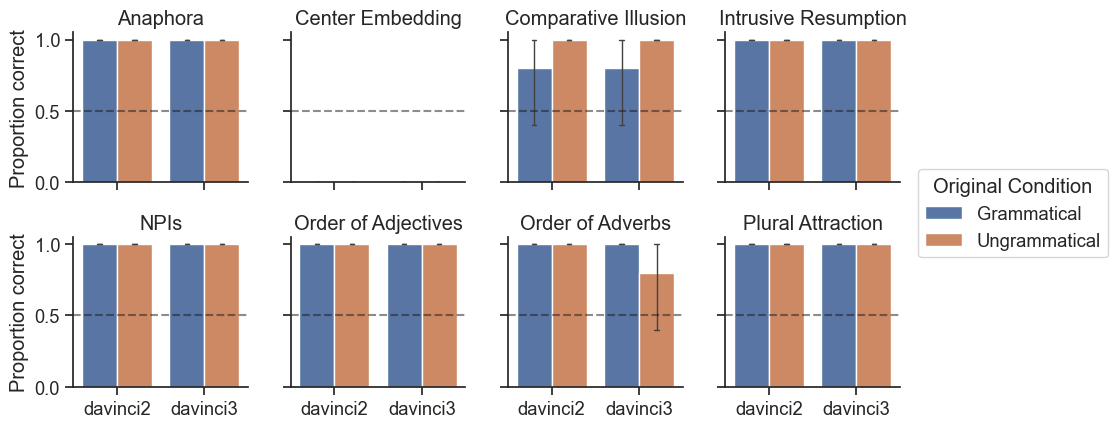

In [6]:
def fig1a_minimal_pair_accuracy(df):
    g = sns.catplot(
        data=df[df.phenomenon!="Plural Attraction control"], 
        col="phenomenon", 
        x="model", 
        order=MODELS,
        y="sum_surprisal_correct", 
        hue="original_condition",
        kind="bar", 
        col_wrap=4,
        height=2.3,
        aspect=1.2,
        capsize=0.1,
        err_kws={'linewidth': 1}
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("", "Proportion correct")
    g.refline(y=0.5, color="k", linestyle="--", alpha=0.5)
    g.set_xticklabels(MODEL_LABELS)
    plt.gcf().set_size_inches(11,4.5)

    g.legend.remove()
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [l.capitalize() for l in labels]
    plt.figlegend(handles, labels, title="Original Condition", loc="center", bbox_to_anchor=(0.92, 0.5))
    
fig1a_minimal_pair_accuracy(mp_df)
render("fig1a_minimal_pair_accuracy.pdf")

# Figure 1b: Surprisal difference vs human acceptance rate

## Step 1: Read and process data from DGL's human experiments

In [7]:
def process_human_data():
    df = pd.read_csv("../data/dgl_original/humans_grammaticality_data.csv")
    df = df[df.phenomenon!="attention check"]
    df["human_judged_as_gramm"] = df.apply(
        lambda r: 1 if (r.condition=="grammatical" and r.accuracy) or (r.condition=="ungrammatical" and not r.accuracy) else 0,
        axis=1
    )
    df["sentence_num"] = df.apply(
        lambda r: get_sentence_num(r.phenomenon, r.test_item),
        axis=1
    )
    return df

human_df = process_human_data()
human_df.head()

,participant,gender,age,language,speech_therapy,mental_conditions,sentence,test_item,phenomenon,condition,accuracy,repetition,stability,human_judged_as_gramm,sentence_num
10,Anaphora__LLM_277486.csv,female,34,english,no,no,The new executive who oversaw the middle manag...,TS 1,Anaphora,grammatical,1,1,NaN,1,3
11,Anaphora__LLM_277486.csv,female,34,english,no,no,The new executive who oversaw the middle manag...,TS 1,Anaphora,grammatical,1,2,0.0,1,3
12,Anaphora__LLM_277486.csv,female,34,english,no,no,The new executive who oversaw the middle manag...,TS 1,Anaphora,grammatical,1,3,0.0,1,3
13,Anaphora__LLM_277486.csv,female,34,english,no,no,The new executive who oversaw the middle manag...,TS 1,Anaphora,grammatical,1,4,0.0,1,3
14,Anaphora__LLM_277486.csv,female,34,english,no,no,The new executive who oversaw the middle manag...,TS 1,Anaphora,grammatical,1,5,0.0,1,3


## Step 2: Get item-specific data (human accuracy & acceptance rates)

In [8]:
def get_item_data(human_df):
    item_data = human_df.groupby("sentence_num")[["human_judged_as_gramm", "accuracy"]].mean()
    item_data.rename(columns={"accuracy": "human_accuracy"}, inplace=True)
    return item_data

item_data = get_item_data(human_df)
item_data.head()

,human_judged_as_gramm,human_accuracy
sentence_num,,
3,0.97,0.97
4,0.40,0.60
5,0.82,0.82
6,0.96,0.96
7,0.92,0.92


In [9]:
def get_surprisal_diff_presented(r):
    if r.original_condition == "grammatical":
        return r.sum_surprisal_grammatical - r.sum_surprisal_ungrammatical
    elif r.original_condition == "ungrammatical":
        return r.sum_surprisal_ungrammatical - r.sum_surprisal_grammatical
    else:
        return None

def get_mp_item_data(mp_df, item_data):
    # Drop a control phenomenon not used in analysis.
    mp_df = mp_df[mp_df.phenomenon!="Plural Attraction control"]
    # Join minimal pair data with item-level human data.
    item_df = mp_df.set_index("sentence_num").join(item_data)
    item_df.reset_index(inplace=True)

    # Add relevant data to the dataframe.
    item_df["sum_surprisal_diff_presented"] = item_df.apply(
        get_surprisal_diff_presented, axis=1
    )

    return item_df

mp_item_df = get_mp_item_data(mp_df, item_data)
mp_item_df.head()

,sentence_num,phenomenon,test_item,original_condition,sentence_grammatical,sentence_ungrammatical,sum_surprisal_grammatical_with_bos,sum_surprisal_ungrammatical_with_bos,model,mean_surprisal_grammatical,...,mean_log_freq_ungrammatical,slor_ungrammatical,sum_surprisal_correct,mean_surprisal_correct,slor_correct,sum_surprisal_diff,mean_surprisal_diff,human_judged_as_gramm,human_accuracy,sum_surprisal_diff_presented
0,3.0,Anaphora,TS 1,grammatical,The new executive who oversaw the middle manag...,The new executive who oversaw the middle manag...,88.110651,89.984150,text-davinci-002,5.874043,...,-8.516348,2.517405,True,True,True,1.873498,0.124900,0.97,0.97,-1.873498
1,3.0,Anaphora,TS 1,grammatical,The new executive who oversaw the middle manag...,The new executive who oversaw the middle manag...,90.774961,93.825885,text-davinci-003,6.051664,...,-8.516348,2.261289,True,True,True,3.050924,0.203395,0.97,0.97,-3.050924
2,4.0,Anaphora,TS 10,ungrammatical,The grimy blacksmith who worked for the royal ...,The grimy blacksmith who worked for the royal ...,89.354419,95.006923,text-davinci-002,4.964134,...,-9.223451,3.945288,True,True,True,5.652504,0.314028,0.40,0.60,5.652504
3,4.0,Anaphora,TS 10,ungrammatical,The grimy blacksmith who worked for the royal ...,The grimy blacksmith who worked for the royal ...,88.520462,94.888374,text-davinci-003,4.917803,...,-9.223451,3.951874,True,True,True,6.367912,0.353773,0.40,0.60,6.367912
4,5.0,Anaphora,TS 2,grammatical,The popular sheriff who campaigned for the inc...,The popular sheriff who campaigned for the inc...,102.717945,108.108957,text-davinci-002,6.042232,...,-8.821103,2.461753,True,True,True,5.391012,0.317118,0.82,0.82,-5.391012


## Step 3: Generate figure

text-davinci-002 -0.7448777486818973 2.3452117027948086e-15
text-davinci-003 -0.672262826222596 8.609626411735934e-12
Rendered figure


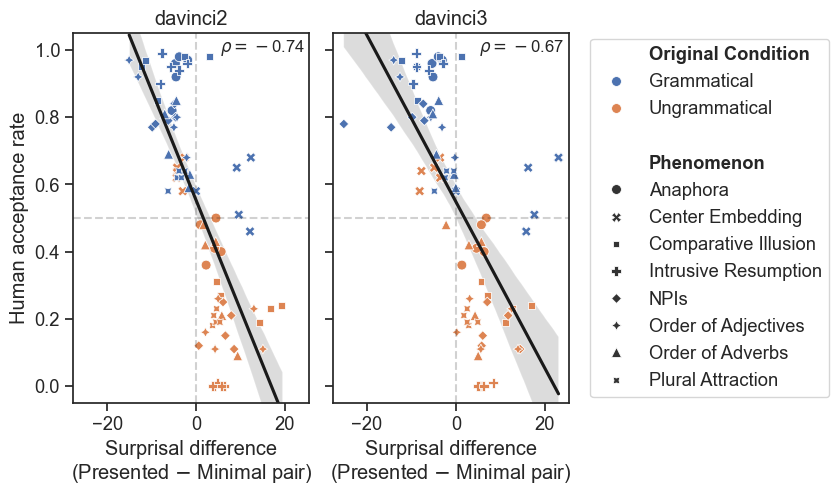

In [10]:
def fig1b_surprisal_diff(mp_item_df):
    model_metric = "sum_surprisal_diff_presented"
    human_metric = "human_judged_as_gramm"

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.1)
    for i, ax in enumerate(axes):
        model = MODELS[i]
        data = mp_item_df[mp_item_df.model==model]
        # Add best-fit regression line.
        ax = sns.regplot(
            data=data,
            x=model_metric,
            y=human_metric,
            scatter=False,
            color="k",
            ax=ax
        )
        # Add scatterplot of points, with colors corresponding to the original condition
        # (seen by humans) and markers corresponding to phenomenon.
        ax = sns.scatterplot(
            data=data,
            x=model_metric,
            y=human_metric,
            hue="original_condition",
            style="phenomenon",
            s=50,
            ax=ax
        )
        # Add reference lines.
        ax.axvline(x=0, linestyle="--", alpha=0.2, color="k")
        ax.axhline(y=0.5, linestyle="--", alpha=0.2, color="k")

        # Legend and axis labels.
        if i == 0:
            ax.get_legend().remove()
            ax.set_ylabel("Human acceptance rate")
        else:
            # Tweak the legend.
            handles, labels = ax.get_legend_handles_labels()
            replacements = {
                "original_condition": "Original Condition",
                "grammatical": "Grammatical",
                "ungrammatical": "Ungrammatical",
                "phenomenon": "Phenomenon"
            }
            for k, v in replacements.items():
                labels[labels.index(k)] = v
            # Add spacer.
            spacer_handle = Patch(visible=False)
            spacer_label = ""
            handles.insert(3, spacer_handle)
            labels.insert(3, spacer_label)
            legend = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5))
            # Make titles bold.
            for text in legend.get_texts():
                if text.get_text() in ["Original Condition", "Phenomenon"]:
                    text.set_weight("bold")
            ax.set_ylabel("")
        ax.set_xlabel("Surprisal difference\n(Presented $-$ Minimal pair)")
        ax.set_ylim(-0.05,1.05)

        xs = data[model_metric]
        ys = data[human_metric]
        r, p = pearsonr(xs, ys)
        print(model, r, p)
        ax.text(0.62, 0.95, f"$\\rho=-${-r:.2f}", size="small", transform=ax.transAxes)
        ax.set_title(MODEL_MAP[model])

fig1b_surprisal_diff(mp_item_df)
render("fig1b_surprisal_difference.pdf")

## Step 4: Save minimal pair with human item-level data

In [11]:
mp_item_df.to_csv("../data/minimal_pair_data.csv", index=False)

# Figure 2a: Human acceptance rates

## Step 1: Compute by-participant acceptance rates

In [12]:
def get_by_participant_acceptance_rates(human_df):
    # First, get long-form data.
    subj_acceptance_rates_long = human_df.groupby(
        ["participant", "phenomenon", "condition"]
    ).human_judged_as_gramm.mean().reset_index()

    # Convert long to wide.
    data = []
    for p in subj_acceptance_rates_long.participant.unique():
        rows = subj_acceptance_rates_long[subj_acceptance_rates_long.participant==p]
        res = dict(
            participant=p,
            phenomenon=rows.phenomenon.values[0],
            acceptance_rate_grammatical=rows[rows.condition=="grammatical"].squeeze().human_judged_as_gramm,
            acceptance_rate_ungrammatical=rows[rows.condition=="ungrammatical"].squeeze().human_judged_as_gramm
        )
        data.append(res)
    subj_acceptance_rates_wide = pd.DataFrame(data)
    return subj_acceptance_rates_wide

subj_acceptance_rates = get_by_participant_acceptance_rates(human_df)
subj_acceptance_rates

,participant,phenomenon,acceptance_rate_grammatical,acceptance_rate_ungrammatical
0,Anaphora__LLM_277486.csv,Anaphora,1.00,1.00
1,Anaphora__LLM_481645.csv,Anaphora,0.84,0.86
2,Anaphora__LLM_511770.csv,Anaphora,0.68,0.28
3,Anaphora__LLM_516302.csv,Anaphora,0.94,0.94
4,Anaphora__LLM_520788.csv,Anaphora,0.98,0.04
...,...,...,...,...
75,Plural Attraction__LLM_662201.csv,Plural Attraction,0.40,0.36
76,Plural Attraction__LLM_669657.csv,Plural Attraction,0.04,0.04
77,Plural Attraction__LLM_672986.csv,Plural Attraction,0.94,0.08
78,Plural Attraction__LLM_886464.csv,Plural Attraction,0.78,0.94


## Step 2: Generate figure

Rendered figure


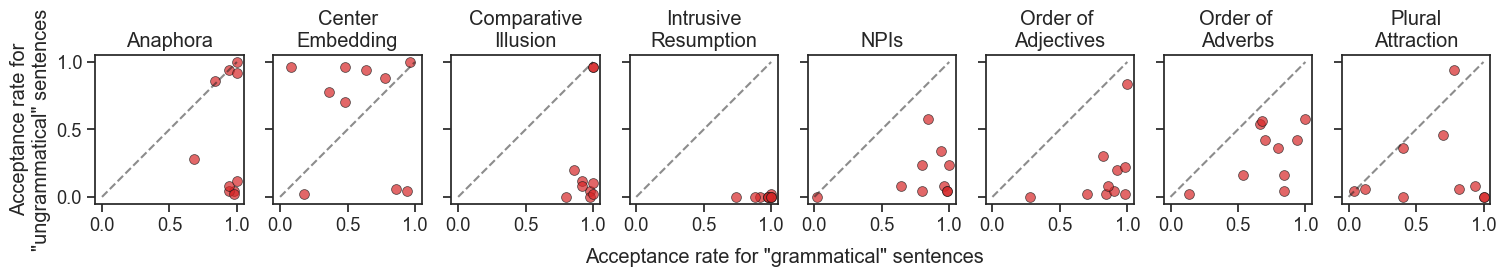

In [13]:
def fig2a_acceptance_rates(subj_acceptance_rates):
    fig, axes = plt.subplots(nrows=1, ncols=len(PHENOMENA), sharex=True, sharey=True, figsize=(18,10))
    for i, ax in enumerate(axes):
        phen = PHENOMENA[i]
        ax = sns.scatterplot(
            data=subj_acceptance_rates[subj_acceptance_rates.phenomenon==phen],
            x="acceptance_rate_grammatical",
            y="acceptance_rate_ungrammatical",
            s=50,
            alpha=0.7,
            edgecolors="k",
            color="tab:red",
            ax=ax
        )
        ax.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle="--", color="k", alpha=0.5)
        ax.set_title(PHENOMENA_LABELS[i])
        ax.set_aspect('equal', adjustable='box')
        if i == 0:
            ax.set_ylabel("Acceptance rate for\n\"ungrammatical\" sentences")

        ax.set_xticks([0, 0.5, 1])
        ax.set_xlabel("")
        if i == 3:
            ax.text(-0.3, -0.4, "Acceptance rate for \"grammatical\" sentences", transform=ax.transAxes)

fig2a_acceptance_rates(subj_acceptance_rates)
render("fig2a_participant_acceptance_rate.pdf")

# Figure 2b: Confusion matrices from human-matched prompt

## Step 1: Read and process model prompt data

In [14]:
def is_correct(response, condition):
    if response == "C" and condition == "grammatical":
        return True
    elif response == "N" and condition == "ungrammatical":
        return True
    return False

def process_prompt_data():
    # First, read the davinci data. These were generated separately 
    # from the GPT-3.5 Turbo and GPT-4 data.
    davinci_df = read_model_csvs("../data/model_outputs/prompting", model_substr="davinci")
    davinci_df.phenomenon = davinci_df.phenomenon.replace({"Comparative Sentences": "Comparative Illusion"})
    davinci_df["sentence_num"] = davinci_df.apply(
        lambda r: get_sentence_num(r.phenomenon, r.test_item),
        axis=1
    )

    # Now, read the GPT-3.5 Turbo and GPT-4 data, which is formatted slightly differently.
    g_df = pd.read_csv("../data/model_outputs/prompting/gpt-3.5-turbo_gpt-4.csv")
    data = []
    meta_vars = [c for c in list(g_df) if "original_prompt" not in c]
    for _, row in g_df.iterrows():
        for model in ["gpt3.5_turbo", "gpt4"]:
            res = {k: row[k] for k in meta_vars}
            res["model"] = model
            res["response_clean"] = row[f"original_prompt_{model}"]
            data.append(res)
    g_df = pd.DataFrame(data)

    # Combine data and add relevant variables.
    df = pd.concat([davinci_df, g_df])
    df["correct"] = df.apply(lambda r: is_correct(r.response_clean, r.condition), axis=1)
    df["judged_as_gramm"] = df.apply(lambda r: r.response_clean == "C", axis=1)
    df = df[df.phenomenon!="attention check"]
    df.model = df.model.replace({
        "text-davinci-002": "davinci2",
        "text-davinci-003": "davinci3",
        "gpt3.5_turbo": "GPT-3.5 Turbo",
        "gpt4": "GPT-4"
    })
    return df

prompt_df = process_prompt_data()
prompt_df.head()

,phenomenon,test_item,condition,sentence,prompt,response,response_clean,model,sentence_num,correct,judged_as_gramm
0,Anaphora,TS 1,grammatical,The new executive who oversaw the middle manag...,Is the following sentence grammatically correc...,The cat slept in the window.\n\nC,C,davinci2,3,True,True
1,Anaphora,TS 2,grammatical,The popular sheriff who campaigned for the inc...,Is the following sentence grammatically correc...,I have a lot of friends that are in high school.,NaN,davinci2,5,False,False
2,Anaphora,TS 3,grammatical,The construction worker who argued with the sh...,Is the following sentence grammatically correc...,"C\n\nThe party was fun, and I enjoyed myself.",C,davinci2,6,True,True
3,Anaphora,TS 4,grammatical,The young caddy who escorted the experienced g...,Is the following sentence grammatically correc...,No sentence provided.,NaN,davinci2,7,False,False
4,Anaphora,TS 5,grammatical,The police officer who aided the brilliant det...,Is the following sentence grammatically correc...,The teacher is going to teach a lesson on the ...,NaN,davinci2,8,False,False


In [15]:
prompt_item_df = prompt_df.set_index("sentence_num").join(item_data).reset_index()
prompt_item_df.head()

,sentence_num,phenomenon,test_item,condition,sentence,prompt,response,response_clean,model,correct,judged_as_gramm,human_judged_as_gramm,human_accuracy
0,3,Anaphora,TS 1,grammatical,The new executive who oversaw the middle manag...,Is the following sentence grammatically correc...,The cat slept in the window.\n\nC,C,davinci2,True,True,0.97,0.97
1,3,Anaphora,TS 1,grammatical,The new executive who oversaw the middle manag...,Is the following sentence grammatically correc...,The cat chased the mouse up the tree.\n\nC,C,davinci3,True,True,0.97,0.97
2,3,Anaphora,NaN,grammatical,The new executive who oversaw the middle manag...,NaN,NaN,C,GPT-3.5 Turbo,True,True,0.97,0.97
3,3,Anaphora,NaN,grammatical,The new executive who oversaw the middle manag...,NaN,NaN,C,GPT-4,True,True,0.97,0.97
4,4,Anaphora,TS 10,ungrammatical,The grimy blacksmith who worked for the royal ...,Is the following sentence grammatically correc...,C,C,davinci2,False,True,0.40,0.60


## Step 2: Compute confusion matrices

In [16]:
def get_confusion_matrices(prompt_item_df):
    confs = defaultdict(dict)
    for phenomenon in PHENOMENA:
        # MODELS
        for model in ["davinci2", "davinci3", "GPT-3.5 Turbo", "GPT-4"]:
            model_rows = prompt_item_df[(prompt_item_df.model==model)&(prompt_item_df.phenomenon==phenomenon)]
            m = np.zeros((2, 2))
            # First row: actually grammatical
            g_rows = model_rows[model_rows.condition=="grammatical"]
            total_g = len(g_rows)
            respond_g = len(g_rows[g_rows.response_clean=="C"])
            respond_u = len(g_rows[g_rows.response_clean=="N"])
            m[0][0] = respond_g / total_g
            m[0][1] = respond_u / total_g

            # Second row: actually ungrammatical
            u_rows = model_rows[model_rows.condition=="ungrammatical"]
            total_u = len(u_rows)
            respond_g = len(u_rows[u_rows.response_clean=="C"])
            respond_u = len(u_rows[u_rows.response_clean=="N"])
            m[1][0] = respond_g / total_u
            m[1][1] = respond_u / total_u

            confs[phenomenon][model] = m

        # HUMANS
        rows = prompt_item_df[(prompt_item_df.phenomenon==phenomenon)]
        m = np.zeros((2, 2))
        # First row: actually grammatical
        g_rows = rows[rows.condition=="grammatical"]
        m[0][0] = g_rows.human_judged_as_gramm.mean()
        m[0][1] = 1 - m[0][0]

        # Second row: actually ungrammatical
        u_rows = rows[rows.condition=="ungrammatical"]
        m[1][0] = u_rows.human_judged_as_gramm.mean()
        m[1][1] = 1 - m[1][0]

        confs[phenomenon]["Human"] = m

    models = confs["Anaphora"].keys() # hacky way to get list of models and "Human"
    for model in models:
        confs["Average"][model] = np.mean(
            [confs[p][model] for p in PHENOMENA], axis=0
        )
    return confs

confusion_mats = get_confusion_matrices(prompt_item_df)

## Step 3: Generate figure

Rendered figure


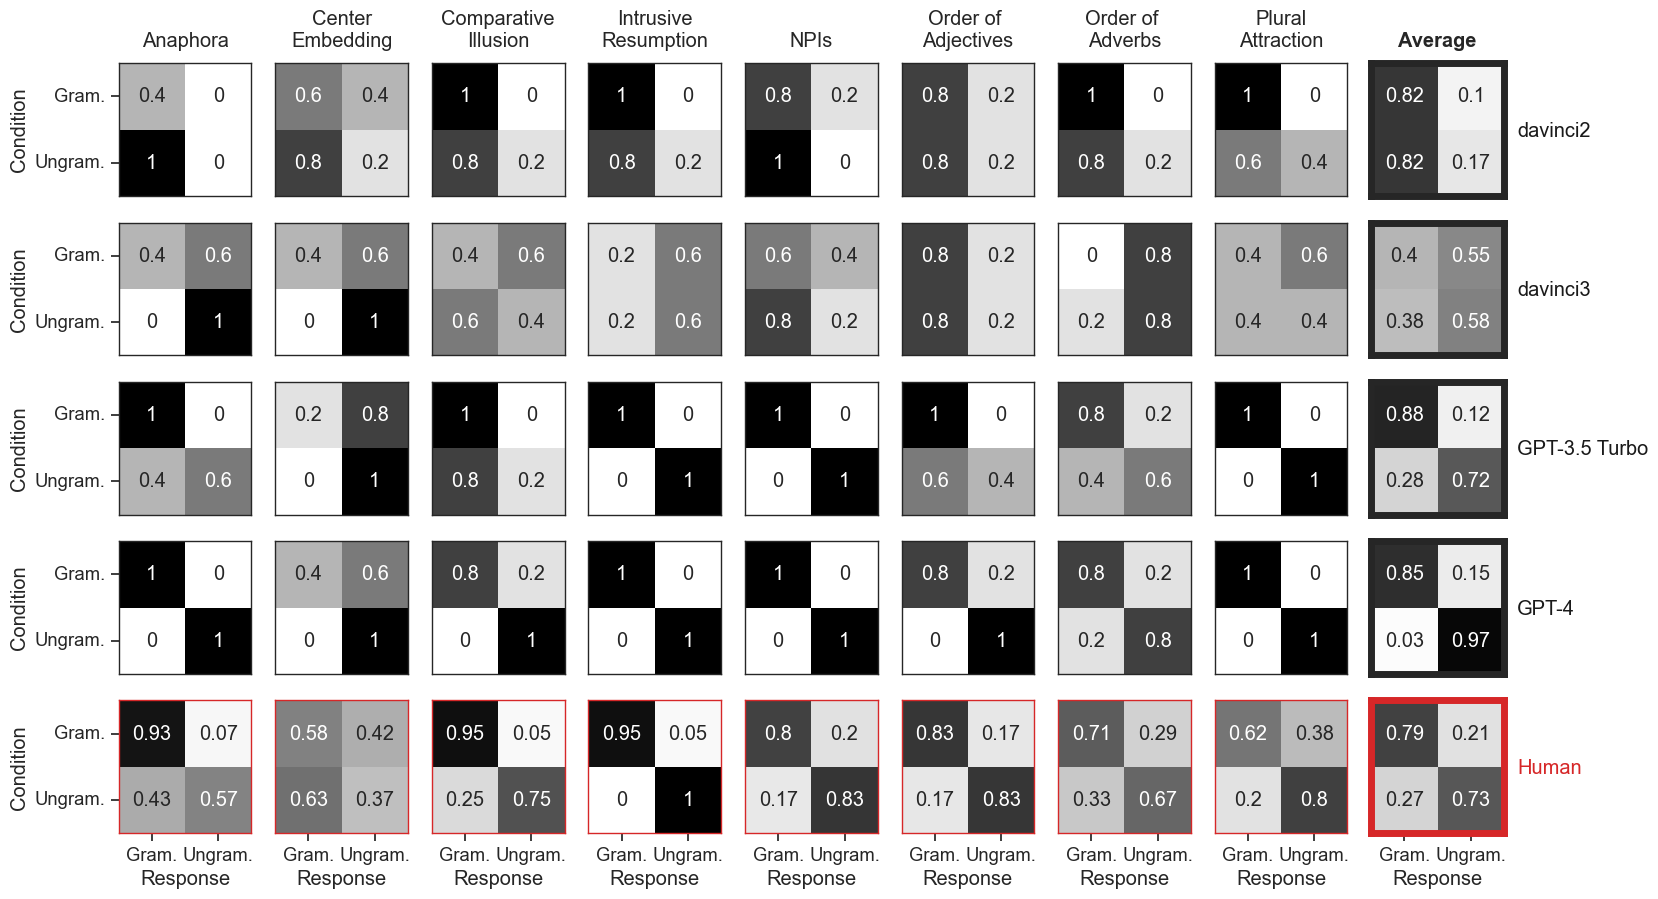

In [17]:
# Heatmap helper function.
def heatmap(m, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    ax = sns.heatmap(
        m, square=True, vmin=0, vmax=1, cmap="Greys", 
        ax=ax, **kwargs
    )
    return ax

def fig2b_confusion_matrices(confs):
    # Plotting constants.
    models_to_plot = ["davinci2", "davinci3", "GPT-3.5 Turbo", "GPT-4", "Human"]
    phenomena = PHENOMENA + ["Average"]
    human_color = "tab:red"
    phen_labels = PHENOMENA_LABELS + ["Average"]

    fig, axes = plt.subplots(nrows=len(models_to_plot), ncols=len(phenomena), 
                             sharey=False, sharex=False, figsize=(18,10))
    plt.subplots_adjust(wspace=0.1)

    for i, model in enumerate(models_to_plot):
        for j, phen in enumerate(phenomena):
            ax = axes[i][j]
            m = confs[phen][model]

            # Get labels.
            labels = []
            for row in m:
                row_labels = []
                for x in row:
                    label = f"{x:.2f}"
                    if label.endswith(".00"):
                        label = label.replace(".00", "")
                    elif label.endswith("0"):
                        label = label[:-1]
                    row_labels.append(label)
                row_sum = sum(eval(l) for l in row_labels)
                labels.append(row_labels)

            ax = heatmap(m, ax=ax, cbar=False, annot=labels, fmt="") #".2f")
            if j == 0:
                ax.set_yticklabels(["Gram.", "Ungram."], rotation=0)
                ax.set_ylabel("Condition")
            else:
                ax.set_ylabel("")
                ax.set_yticks([])

            if i == 0:
                ax.set_title(phen_labels[j], pad=12, fontweight="bold" if phen == "Average" else "normal")
                ax.set_xlabel("")
                ax.set_xticks([])
            elif i == len(models_to_plot)-1:
                ax.set_xlabel("Response")
                ax.set_xticklabels(["Gram.", "Ungram."])
                ax.set_title("")
            else:
                ax.set_xticks([])

            for _, spine in ax.spines.items():
                spine.set_visible(True)
                if phen == "Average":
                    spine.set(lw=5)
                else:
                    spine.set(lw=1)
                if model == "Human":
                    spine.set(color=human_color)

    # Add model labels. Doing it at the axis-level creates weird spacing issues.
    for i, model in enumerate(models_to_plot):
        ax = axes[i][len(phenomena)-1]
        y = 0.45
        ax.text(1.1, y, model, transform=ax.transAxes, color=human_color if model=="Human" else "k")
    
fig2b_confusion_matrices(confusion_mats)
render("fig2b_confusion_matrices.pdf")

In [18]:
# Get proportion of model prompt responses that were not codeable
n_uncodable_responses = len(prompt_item_df[prompt_item_df.response_clean.isna()])
print("davinci only:", n_uncodable_responses / len(prompt_item_df[prompt_item_df.model.str.contains("davinci")]))
print("Total:", n_uncodable_responses / len(prompt_item_df))

davinci only: 0.04375
Total: 0.021875
